# Seasonal Naive Approach

Benchmark model that simply forecasts the same value from the previous seasonal period.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
matplotlib.rcParams['figure.figsize'] = (16, 9)
pd.options.display.max_columns = 999

## Load Dataset

In [3]:
df = pd.read_csv('../datasets/household-electricity.csv', parse_dates=[0], index_col='DateTime')
print(df.shape)
df.head()

(26305, 321)


,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9,ts10,ts11,ts12,ts13,ts14,ts15,ts16,ts17,ts18,ts19,ts20,ts21,ts22,ts23,ts24,ts25,ts26,ts27,ts28,ts29,ts30,ts31,ts32,ts33,ts34,ts35,ts36,ts37,ts38,ts39,ts40,ts41,ts42,ts43,ts44,ts45,ts46,ts47,ts48,ts49,ts50,ts51,ts52,ts53,ts54,ts55,ts56,ts57,ts58,ts59,ts60,ts61,ts62,ts63,ts64,ts65,ts66,ts67,ts68,ts69,ts70,ts71,ts72,ts73,ts74,ts75,ts76,ts77,ts78,ts79,ts80,ts81,ts82,ts83,ts84,ts85,ts86,ts87,ts88,ts89,ts90,ts91,ts92,ts93,ts94,ts95,ts96,ts97,ts98,ts99,ts100,ts101,ts102,ts103,ts104,ts105,ts106,ts107,ts108,ts109,ts110,ts111,ts112,ts113,ts114,ts115,ts116,ts117,ts118,ts119,ts120,ts121,ts122,ts123,ts124,ts125,ts126,ts127,ts128,ts129,ts130,ts131,ts132,ts133,ts134,ts135,ts136,ts137,ts138,ts139,ts140,ts141,ts142,ts143,ts144,ts145,ts146,ts147,ts148,ts149,ts150,ts151,ts152,ts153,ts154,ts155,ts156,ts157,ts158,ts159,ts160,ts161,ts162,ts163,ts164,ts165,ts166,ts167,ts168,ts169,ts170,ts171,ts172,ts173,ts174,ts175,ts176,ts177,ts178,ts179,ts180,ts181,ts182,ts183,ts184,ts185,ts186,ts187,ts188,ts189,ts190,ts191,ts192,ts193,ts194,ts195,ts196,ts197,ts198,ts199,ts200,ts201,ts202,ts203,ts204,ts205,ts206,ts207,ts208,ts209,ts210,ts211,ts212,ts213,ts214,ts215,ts216,ts217,ts218,ts219,ts220,ts221,ts222,ts223,ts224,ts225,ts226,ts227,ts228,ts229,ts230,ts231,ts232,ts233,ts234,ts235,ts236,ts237,ts238,ts239,ts240,ts241,ts242,ts243,ts244,ts245,ts246,ts247,ts248,ts249,ts250,ts251,ts252,ts253,ts254,ts255,ts256,ts257,ts258,ts259,ts260,ts261,ts262,ts263,ts264,ts265,ts266,ts267,ts268,ts269,ts270,ts271,ts272,ts273,ts274,ts275,ts276,ts277,ts278,ts279,ts280,ts281,ts282,ts283,ts284,ts285,ts286,ts287,ts288,ts289,ts290,ts291,ts292,ts293,ts294,ts295,ts296,ts297,ts298,ts299,ts300,ts301,ts302,ts303,ts304,ts305,ts306,ts307,ts308,ts309,ts310,ts311,ts312,ts313,ts314,ts315,ts316,ts317,ts318,ts319,ts320,ts321
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,12.690355,68.278805,231.972198,412.601626,213.414634,1053.571429,27.133974,838.383838,223.776224,263.440860,177.347243,145.936982,109.125718,169.703872,227.313567,1000.000000,47.738693,160.352423,591.623037,86.550436,31.662269,0.0,883.177570,121.186441,101.096224,423.484119,182.842830,358.552632,0.0,81.703911,447.257384,34.423408,406.189555,345.549738,519.230769,175.349428,4045.454545,149.823322,216.582064,810.426540,110.169492,66.457352,4130.434783,782.918149,182.948490,165.123457,323.149236,276.978417,222.222222,156.234097,126.064736,510.603589,500.438982,124.370594,405.560098,291.286307,135.350318,3974.358974,278.571429,265.563436,680.161943,670.533643,835.443038,214.238190,190.476190,395.494368,117.706237,451.682953,287.671233,288.349515,123.655914,241.234956,129.695252,75.949367,438.502674,156.976744,378.832839,794.303797,596.424010,1831.578947,435.356201,404.444444,1087.301587,50.868486,356.237492,6.091371,27.791814,12.048193,26.086957,294.117647,655.683690,878.90625,36.617843,749.128920,1766.182299,745.762712,600.000000,164.841183,526.490066,331.769437,521.276596,189.801700,325.358852,25.110783,68.163593,453.997809,401.938591,60.527677,426.881720,118.701964,173.062453,1452.560873,609.467456,17.453799,49.773756,503.271538,249.852333,0.0,7951.219512,1011.235955,76.271186,104.039168,219.096334,416.579224,102.428722,422.222222,193.986276,2786.743516,56.122995,77.404215,5540.123457,1084.835631,5188.940092,610.906411,1712.747253,0.0,188.397291,65.417867,516.827795,243.623910,0.0,305.161290,261.661184,136.398010,0.0,225.241810,89.568966,129.733728,0.0,5.219985,59.108138,632.492114,669.794721,2532.374101,859.060403,511.196068,5148.305085,648.054146,26958.333333,239.247312,328.802589,767.201835,1091.409692,444.093493,530.140845,715.053763,1452.238806,824.152542,245.131730,1068.027211,11302.521008,820.3

## Define Parameters

Make predictions for 24-hour period using a seasonality of 24-hours.

In [4]:
dataset_name = 'Household Electricity Consumption'
dataset_abbr = 'HEC'
context_length = 24
prediction_length = 24

## Define Error Metric

The seasonal variant of the mean absolute scaled error (MASE) will be used to evaluate the forecasts.

In [5]:
def calc_sMASE(training_series, testing_series, prediction_series, seasonality=prediction_length):
    a = training_series.iloc[seasonality:].values
    b = training_series.iloc[:-seasonality].values
    if len(a) != 0:
        d = np.sum(np.abs(a-b)) / len(a)
    else:
        return 1
    errors = np.abs(testing_series - prediction_series)
    return np.mean(errors) / d

## Evaluate Seasonal Naive Model

In [6]:
results = df.copy()
for i, col in enumerate(df.columns):
    results['pred%s' % str(i+1)] = results[col].shift(context_length)
results.dropna(inplace=True)

In [7]:
sMASEs = []
for i, col in enumerate(df.columns):
    sMASEs.append(calc_sMASE(results[col].iloc[-(context_length + prediction_length):-prediction_length],
                             results[col].iloc[-prediction_length:],
                             results['pred%s' % str(i+1)].iloc[-prediction_length:]))

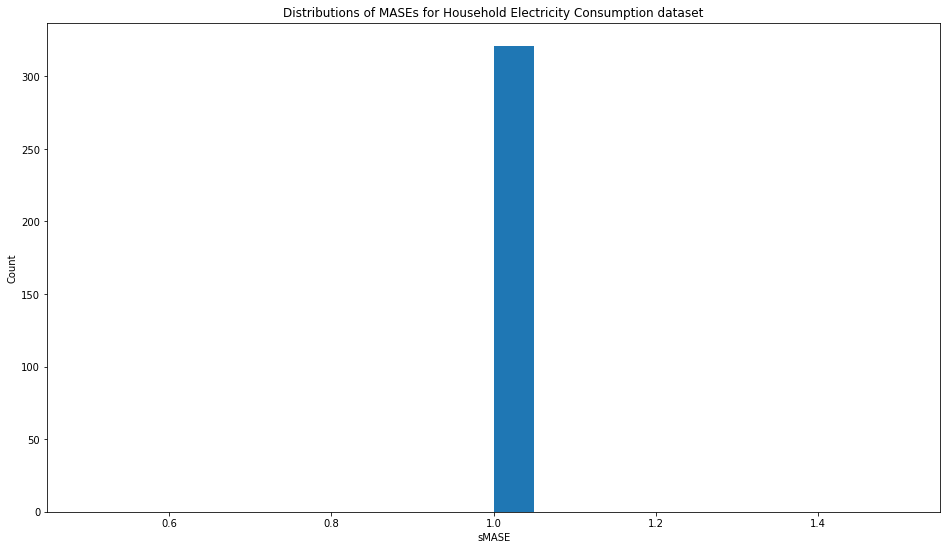

In [8]:
fig, ax = plt.subplots()
ax.hist(sMASEs, bins=20)
ax.set_title('Distributions of MASEs for {} dataset'.format(dataset_name))
ax.set_xlabel('sMASE')
ax.set_ylabel('Count');

In [9]:
sMASE = np.mean(sMASEs)
print("Overall sMASE: {:.4f}".format(sMASE))

Overall sMASE: 1.0000


Show some example forecasts.

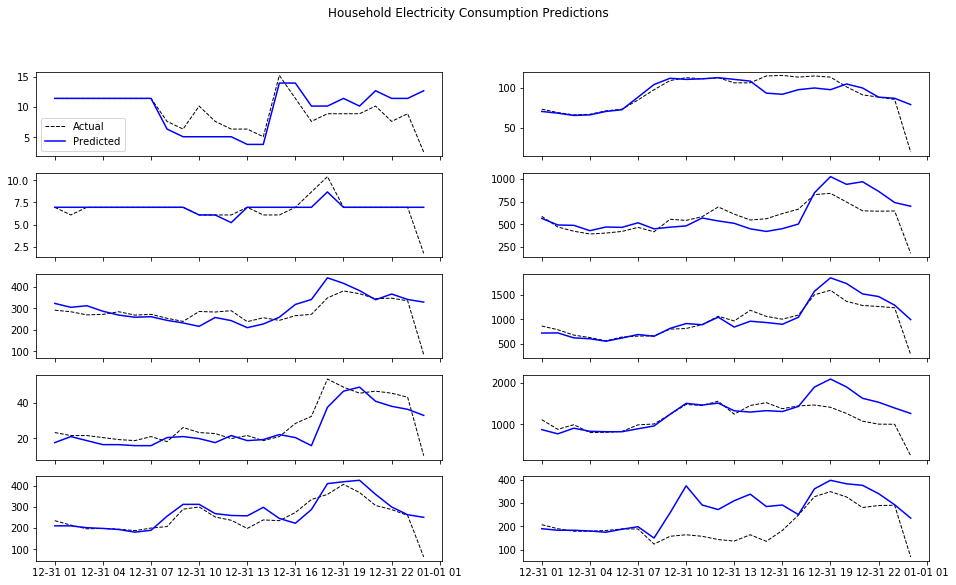

In [10]:
fig, ax = plt.subplots(5, 2, sharex=True)
ax = ax.ravel()

for col in range(1, 11):
    ax[col-1].plot(results.index[-prediction_length:], results['ts%s' % col].iloc[-prediction_length:],
                   label='Actual', c='k', linestyle='--', linewidth=1)
    ax[col-1].plot(results.index[-prediction_length:], results['pred%s' % col].iloc[-prediction_length:],
                   label='Predicted', c='b')
fig.suptitle('{} Predictions'.format(dataset_name))
ax[0].legend();

Store the predictions and accuracy score for the Seasonal Naive Approach models.

In [11]:
import pickle
    
with open('{}-sMASE.pkl'.format(dataset_abbr), 'wb') as f:
    pickle.dump(sMASE, f)
    
with open('../_results/Naive/{}-results.pkl'.format(dataset_abbr), 'wb') as f:
    pickle.dump(results.iloc[-prediction_length:], f)